# Tutorial 3: Particle Filters

Welcome to tutorial 3 of the tutorials. Last week we looked at grid localization, this week we will be looking at particles filters.

## 1 - Packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from copy import copy as copy

## 2 - Outline of the Tutorial

**Objectives:**
* Define the robot's environment i.e. robot moves, action and measurement noise
* Learn how to use particle filters 
* Understand the concept of importance sampling and how it is used in particle filters

In last week's tutorial we looked at grid localization, which is suitable for small-scale problems i.e. a grid of small size. Grid localization has limitations when applied to larger scale problems:
* The continuous space is discretized into finite grids
* Higher grid resolution requires more memory storage
* Once discretized, the resolution of the grid is fixed, no way of adapting memory allocation 

Particle filters however, can overcome these problems. The key idea behind using particle filters is to represent the belief $bel(x_t)$ using a set of samples or particles drawn from posterior belief rather than using the entire distribution. In other words, particle filters approximate the belief $bel(x_t)$ by a set of particles:

$\chi_t := x^{[1]}_t, x^{[2]}_t,...,x^{[M]}_t$

Each particle $x^{[m]}_t$ is a hypothesis as to what the true world state may be at time $t$. $M$ denotes the number of particles in a set $\chi_t$.


<img src="images/sense_move_act.png" style="width: 600px;">

Similar to last weeks tutorial on grid localization, the robot follows the same loop of moving and sensing. However instead of using a grid localization method, we will be using a particle filter for state estimation. The figure below shows the robot (red circle) in its state space. The orange circles show landmarks within the state space. The robot uses these landmarks in order to localize itself within the state space. 

<img src="images/particle_filter.png" style="width: 600px;">

### Define Utility Functions
Define Gaussian function which will be used later for the measurement model "likelihood".

In [2]:
def gaussian(mu, sigma, x):        
    # Given a x position, mean mu and std sigma of Gaussian, calculates the probability
    # Note
    # mu: estimated distance by each particle's position, (map and landmarks are known)
    # x:  measured distance by the robot
    return np.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * np.pi * (sigma ** 2))

## 3 - Define Robot World

Build the robot's world, defining the motion model, sensing function and the likelihood evaluation function: 
* Create simulated sensing: $Z_t = d(x_t) + \mathcal{N}(0, \sigma^2) $, where $d(x_t)$ is the actual distance to the landmark and $\mathcal{N}(0, \sigma^2)$ is Gaussian noise from the sensor

* Motion model equation: $ p(x^{[m]}_{t}$ | $u_t, x^{[m]}_{t-1}$)
* Measurement model "importance factor": $ p(z_t$ | $ x^{[m]}_{t}) $

In [3]:
world_size = 100.0
landmarks  = [[50.0, 50.0], [world_size, world_size], [0.0, world_size], [world_size, 0.0]]

class Robot(object):
    def __init__(self):
        #  random.random() returns random number in [0.0, 1.0)
        self.x = np.random.rand() * world_size
        self.y = np.random.rand() * world_size
        self.orientation = np.random.rand() * 2.0 * np.pi
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 0.0;
    
    def set_pose(self, new_x, new_y, new_orientation):
        # Define limits for robot
        # Can set the pose of the robot after initialization
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * np.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # possibility to set noise parameters for forward, turn and sensing
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    def sense(self):
        # Measure the distance to landmarks with some noise
        Z = []
        for i in range(len(landmarks)):
            # given its position x, y, measure the distance to each landmark
            dist = np.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            # superimpose a gaussian noise on ideal measurement
            dist += np.random.randn()*self.sense_noise
            Z.append(dist)
        return Z
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')         
        
        # turn, and add Gaussian noise to the turning command
        orientation = self.orientation + float(turn) + np.random.randn()*self.turn_noise
        orientation %= 2 * np.pi # make sure: 0=< orientation <=2*pi 
        
        # move, and add Gaussian noise to the motion command
        dist = float(forward) + np.random.randn()*self.forward_noise
        x = self.x + (np.cos(orientation) * dist)
        y = self.y + (np.sin(orientation) * dist)
        x %= world_size    # make sure: 0=< position <= world_size
        y %= world_size
        
        # set the new location x, y back to the member variables x y of the class
        self.set_pose(x, y, orientation)
        return None
    
    def measurement_prob(self, measurement):        
        # calculates how likely a measurement should be based on a Gaussian distribution        
        prob = 1.0;
        for i in range(len(landmarks)):
            # calculate probability of being in a location given a measurement 
            dist = np.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= gaussian(dist, self.sense_noise, measurement[i])
            # the final probability is the multiplication of each measurement probability
        return prob
    
    def __repr__(self):
        # return a printable pose of the robot
        return 'Robot pose is: [x=%.5s y=%.5s orient=%.5s]' % (str(self.x), str(self.y), str(self.orientation))

### Plotting Functions for Robot

In [4]:
def show(x):
    print(np.around(x,decimals=3))
        
        
def plotRobot(robot):
    # Used for visualizing the robot and landmarks on scatter plot 

    plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
    
    # Plotting the landmarks 
    for l in landmarks:
        plt.scatter(l[0], l[1], c='c', s =1000)
        
    # Plotting robot position     
    plt.scatter(robot.x, robot.y, c='r', s=500)
    
    # Plotting robot orientation     
    plt.quiver(robot.x, robot.y, 5,5, angles=np.rad2deg(robot.orientation), scale=1/5, scale_units="dots",
          units="dots", color="k", pivot="mid",width=2.5, headwidth=5, headlength=2.5)
    
    plt.xlim(0, world_size)
    plt.ylim(0, world_size)
    plt.show(block=False)  


### Test Previously Defined Functions and Class

**Tasks:** 
1. Use the motion model and the measurement model
2. Modify the motion command and the uncertainties of motion to see how the robot moves
3. Use measurement model to obtain landmark measurement and modify uncertainties of the sensing to see it senses


Distance from 4 landmarks
[-0.    70.698 70.722 70.72 ]
Robot location 
 Robot pose is: [x=50.0 y=50.0 orient=0.0]


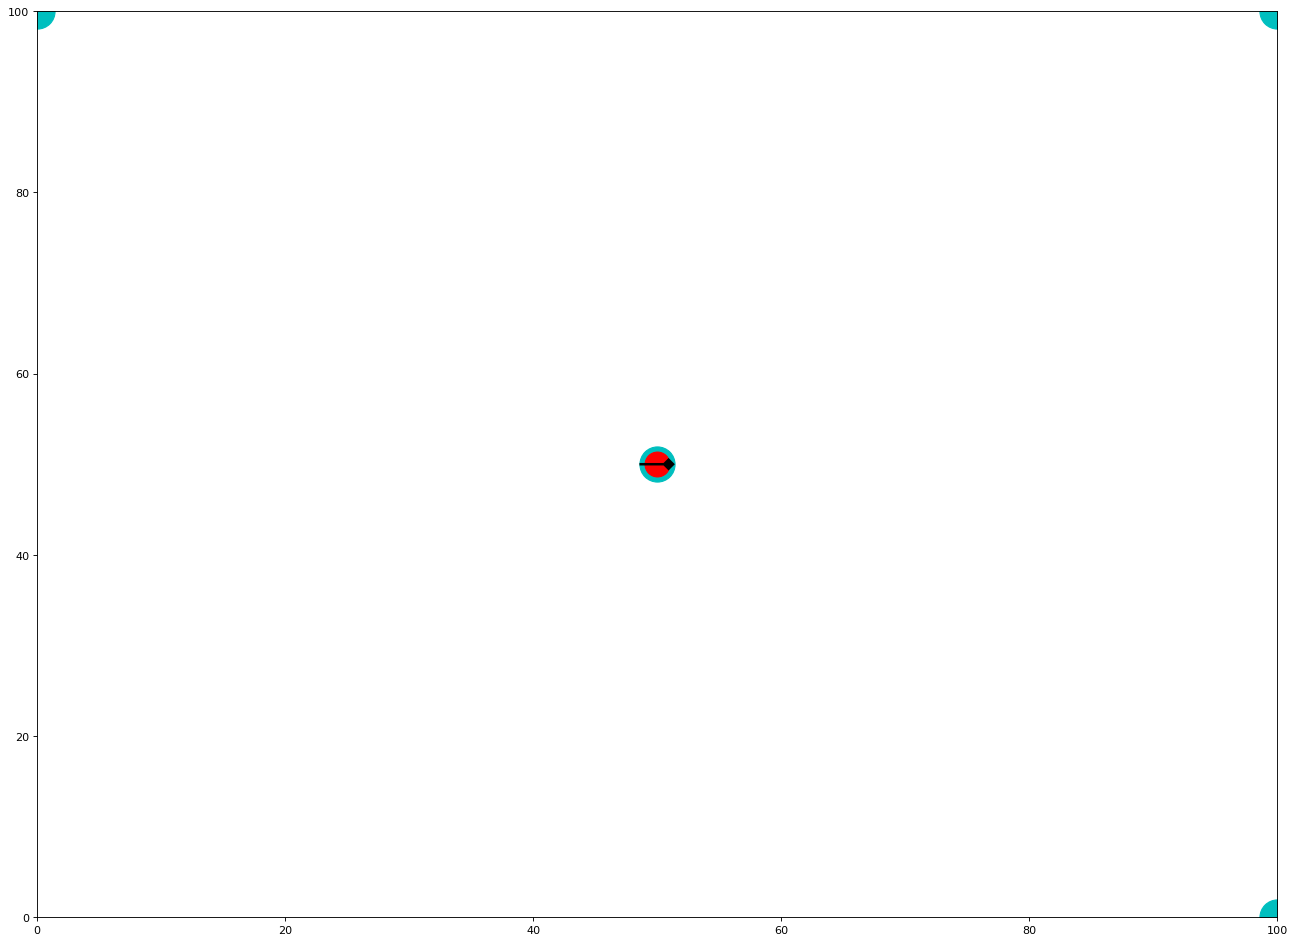


Distance from 4 landmarks
[ 9.991 60.708 71.505 71.325]


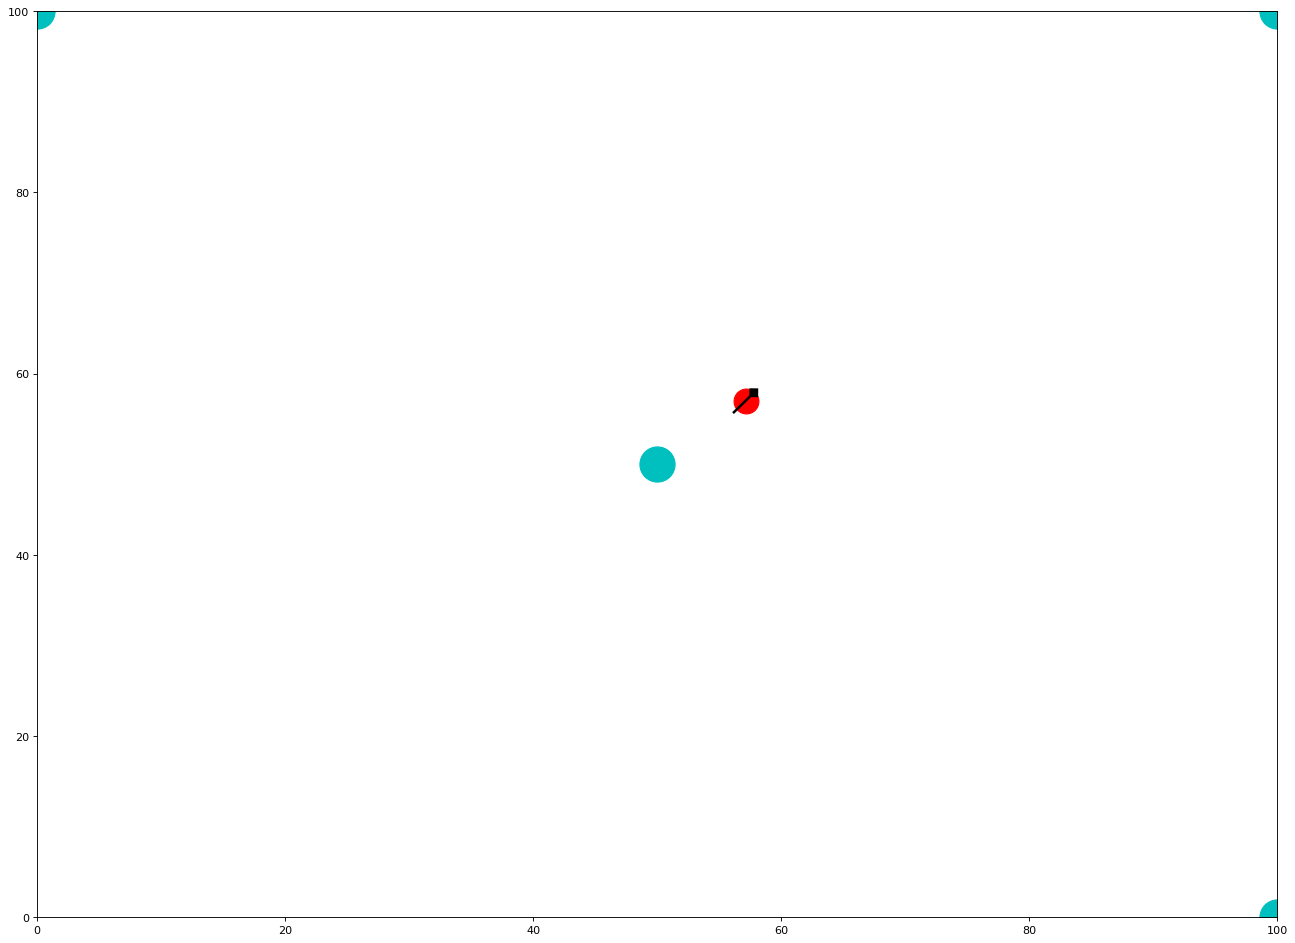


Distance from 4 landmarks
[23.167 51.158 63.673 83.779]


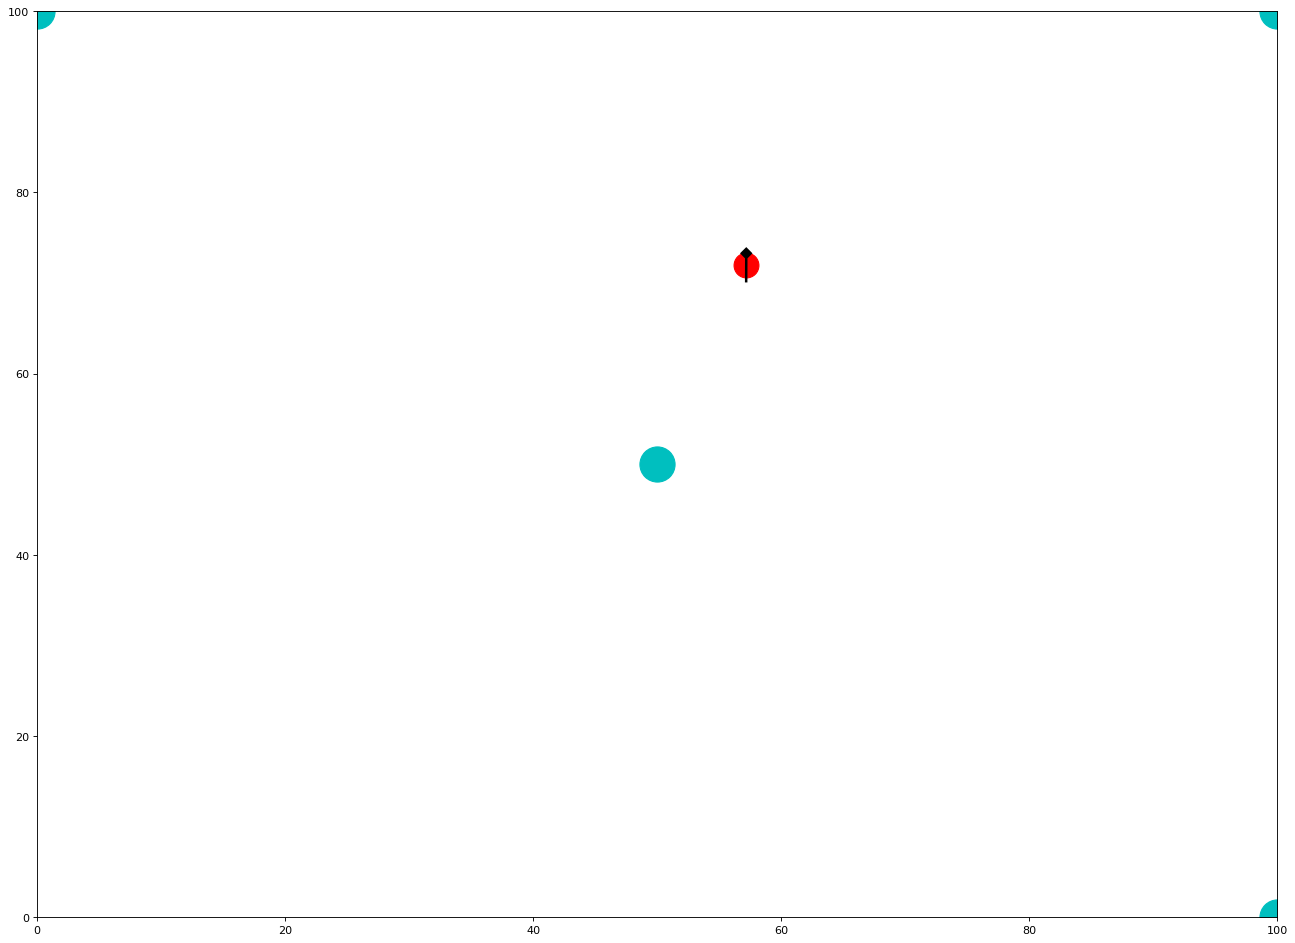

In [5]:
# init robot
robot = Robot()
# set noise levels
robot.set_noise(0.01, .01, 0.01)

# set an initial position for the robot at the centre of the environment
robot.set_pose(50.0, 50.0, 0*np.pi/2) 
print('\nDistance from 4 landmarks')
show(robot.sense())
print('Robot location \n', robot)
# plot robot in environment
plotRobot(robot)

# Move the robot 10 steps at an orientation of 45 degrees (plotting robot position) 
# and obtain a measurement of the landmarks
### START CODE HERE ### (~ 3-5 lines of code)
robot.move(np.pi/4, 10)
print('\nDistance from 4 landmarks')
show(robot.sense())
plotRobot(robot)
### END CODE HERE ###

# Move the robot 15 steps up from this position
# and obtain a measurement of the landmarks
### START CODE HERE ### (~ 3-5 lines of code)
robot.move(np.pi/4, 15)
print('\nDistance from 4 landmarks')
show(robot.sense())
plotRobot(robot)
### END CODE HERE ###

# Robot objects are mutable! 
# a mutable object can be changed after it is created
robot_array = []
robot_array.append(robot)
robot_array.append(robot)
robot_array.append(copy(robot))
robot.move(0,10)

#print('\nShowing off the mutability of Robot')
#print('Array problem \n', robot_array[1])
#print('Array solution \n', robot_array[-1])

### Additional Plotting Function For Particles and Robot

In [6]:
def plotParticles(robot, particles):
    # Used for visualizing the particles, robot and landmarks on scatter plot 
    
    plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
    
    # Plotting the particles
    for p in particles:
        plt.scatter(p.x, p.y, c='b')
        plt.quiver(p.x, p.y, 1,1, angles=np.rad2deg(p.orientation), scale=1/5, scale_units="dots", 
                   units="dots", color="y", pivot="mid",width=1.25, headwidth=2, headlength=0.5)

    # Plotting the landmarks 
    for l in landmarks:
        plt.scatter(l[0], l[1], c='c', s =1000)
        
    # Plotting robot position     
    plt.scatter(robot.x, robot.y, c='r', s=500)
    
    # Plotting robot orientation     
    plt.quiver(robot.x, robot.y, 5,5, angles=np.rad2deg(robot.orientation), scale=1/5, scale_units="dots",
          units="dots", color="k", pivot="mid",width=2.5, headwidth=5, headlength=2.5)
    
    plt.xlim(0, world_size)
    plt.ylim(0, world_size)
    plt.show(block=False)

## 4 - Particle Filter Algorithm

<img src="images/particle_filter_pseudo.png" style="width: 600px;">

**Line-by-line Description:**

**Line 1.** The particle filter has the previous particle set $\chi_{t-1}$, latest action $u_t$ and latest sensor reading $z_t$ as inputs

**Line 2.** The temporary particle set $\bar{\chi}_t$ is initialized

**Line 3.** Looping over each particle with index $m$ over number of particles $M$

**Line 4.** Generate a hypothetical state $x^{[m]}_t$ using the motion model: $ p(x^{[m]}_{t}$ | $u_t, x^{[m]}_{t-1}$)

**Line 5.** Calculate the importance factor or weight $w^{[m]}_t$ using the measurement model: $p(z_t | x^{[m]}_t)$

**Line 6.** Add the weights and particles to temporary particle set $\bar{\chi}_t$

**Lines 8-11.** Implement resampling or importance sampling:
* Loop through the set of particles, drawing particles from the temporary particle set $\bar{\chi}_t$. 
* The probability of drawing each particle is given by its importance weight $w^{[m]}_t$.
* Resampling updates the particle set, incorporating the weights to change the distribution of particles. 

### Particle Filter Algorithm Implementation
**Task:**
Change the particle update function to use the stochastic universal sampling method.

In [7]:
class ParticleFilterStateEstimator(object):
    def __init__(self, noParticles):
        self.particles = []
        self.weights = []
        # create a list of particles with random initial state
        for _ in range(noParticles):
            p = Robot()
            p.set_noise(0.1, 0.1, 5.0)
            self.particles.append(p)
    
    # update the pose of each particle according to the motion model defined above function "move()"  
    # where action is a list of [delta in heading, delta in forward motion]    
    def actionUpdate(self, action):
        for p in self.particles:
            p.move(action[0],action[1])

    # Measurement model - importance factor:
    def measurementUpdate(self, measurement):      
        weights = []
        for p in self.particles:
            # Obtain weight w 
            weights.append(p.measurement_prob(measurement))
        
        # Normalize w (total probability)
        ### START CODE HERE ### (~1-2 lines of code)
        self.weights = [w/sum(weights) for w in weights]
        ### END CODE HERE ###
    
    # Particle update: given each particle's position, what is the probability 
    # of being at that position given Z measurement          
    def particleUpdate(self):      
        self.particles = stochasticUniversalSampling(self.particles, self.weights)

## 5 - Resampling 

The resampling or importance sampling step can be thought of as a probabilistic implementation of the Darwinian idea of *survival of the fittest*. It refocuses the particle set to regions in the state space with higher probability. By doing so, it focuses computational resources of the filter algorithm more efficiently. 

Before the resampling step, the particles were distributed according to the motion model, giving $\bar{bel}(x_t)$. After resampling, (lines 8-11) the particles are redistributed according to the posterior: $bel(x_t)$ =  $p(z_t | x^{[m]}_t)$ $ p(x^{[m]}_{t}$ | $u_t, x^{[m]}_{t-1}$). This results in a new particle distribution after one motion model update and one measurement model update.

The figure below shows this process:

(a) The target density f which corresponds to $bel(x_t)$ 

(b) The actual density g, who's distribution is sampled according to the motion model i.e. $\bar{bel}(x_t)$. Particle samples for g are also shown, taken according to line 4 in the algorithm.

(c) Particles are redistrubuted or resampled from f by attaching the weights to each particle.

<img src="images/importance_sampling.png" style="width: 600px;">

### Resampling Algorithm Implementation

One significant source of error in particle filters is that whenever samples are drawn from a probability density, the extracted statistics (e.g. mean and variance) of these samples will be slightly different to the statistics of the original probability density. This is called *Sampling Variance* and is worsened when repeated resampling occurs, such as in a particle filter.

This problem can be addressed by not selecting samples independently of each other during the resampling process, but instead by using a sequential stochastic process. Two sequential resampling algorithms are provided below:

In [8]:
def resampling(particles, w):
    N = len(particles)
    beta=0
    index=0
    w_max= max(w)
    p_temp=[]
    for i in range(N):
        beta= beta+2.0*w_max*np.random.rand()
        while beta>w[index]:
            beta = beta - w[index]
            index=(index + 1) % N
        selectedParticle = copy(particles[index])
        p_temp.append(selectedParticle) # if beta<w[index], this indexed particle is selected
    return p_temp

def stochasticUniversalSampling(particles, weights):
    N = len(particles)
    beta = np.random.rand()/N
    index = 0    
    p_temp = []
    for i in range(N):
        beta += 1.0/N
        while beta>weights[index]:
            beta = beta - weights[index]
            index= (index + 1) % N
        selectedParticle = copy(particles[index])
        p_temp.append(selectedParticle) # if beta<w[index], this indexed particle is selected 
    return p_temp

Simple evaluation function, regarding the accuracy (compare against ground truth) of the estimation (localization) process:

In [9]:
def evaluation(robot, particles):
    # Gives the mean error in position between the robot's
    # actual position and the set of particles
    sum = 0.0;
    for p in particles: # calculate mean error 
        dx = (p.x - robot.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p.y - robot.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = np.sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(particles))

## 6 - Test Particle Filter Localization 
Test the particle filter localization using the developed functions and class.

**Tasks:** 
1. Fill in the missing parts of the particle filter algorithm, using functions from the *ParticleFilterStateEstimator* class
2. Use and compare the two differrent resampling algorithms. (Tip: modify function *particleUpdate()* in *ParticleFilterStateEstimator* class)

In [10]:
def main():
    # Create an object called "myrobot", which we will use as the real robot, enter code below.
    # Note: that robot does not have noise, we need this info as ground truth
    myrobot = Robot()
    myrobot.set_pose(0.0, 0.0, 0)   
    myrobot.set_noise(0.1, 0.1, 0.1)
    
    # Set the motion the robot will perform
    steps=10
    heading = 10.0/180.0*np.pi
    steplength = 10.0
    
    # Initialize the state estimator
    estimator = ParticleFilterStateEstimator(1000)
    # plot robot, environment and particles    
    plotParticles(myrobot, estimator.particles)
    
    # for each step update the belief     
    for s in range(steps):
        
        # Implement the particle filter algorithm
        # move robot         
        myrobot.move(heading, steplength)
        
        # update pose of each particle according to the motion model         
        ### START CODE HERE ### (~1 line of code)
        estimator.actionUpdate([heading, steplength])
        ### END CODE HERE ###
        
        # obtain a sensor reading         
        measurement = myrobot.sense()
        
        # update the weights of the particles according to the measrement model 
        ### START CODE HERE ### (~1 line of code)
        estimator.measurementUpdate(measurement)
        ### END CODE HERE ###
        
        # update the particles according to resampling process 
        ### START CODE HERE ### (~1 line of code)
        estimator.particleUpdate()
        ### END CODE HERE ###
        
        print('Step: ',  s) 
        print('Robot location:', myrobot) 
        print("Mean error:",evaluation(myrobot, estimator.particles))
        plotParticles(myrobot, estimator.particles)        

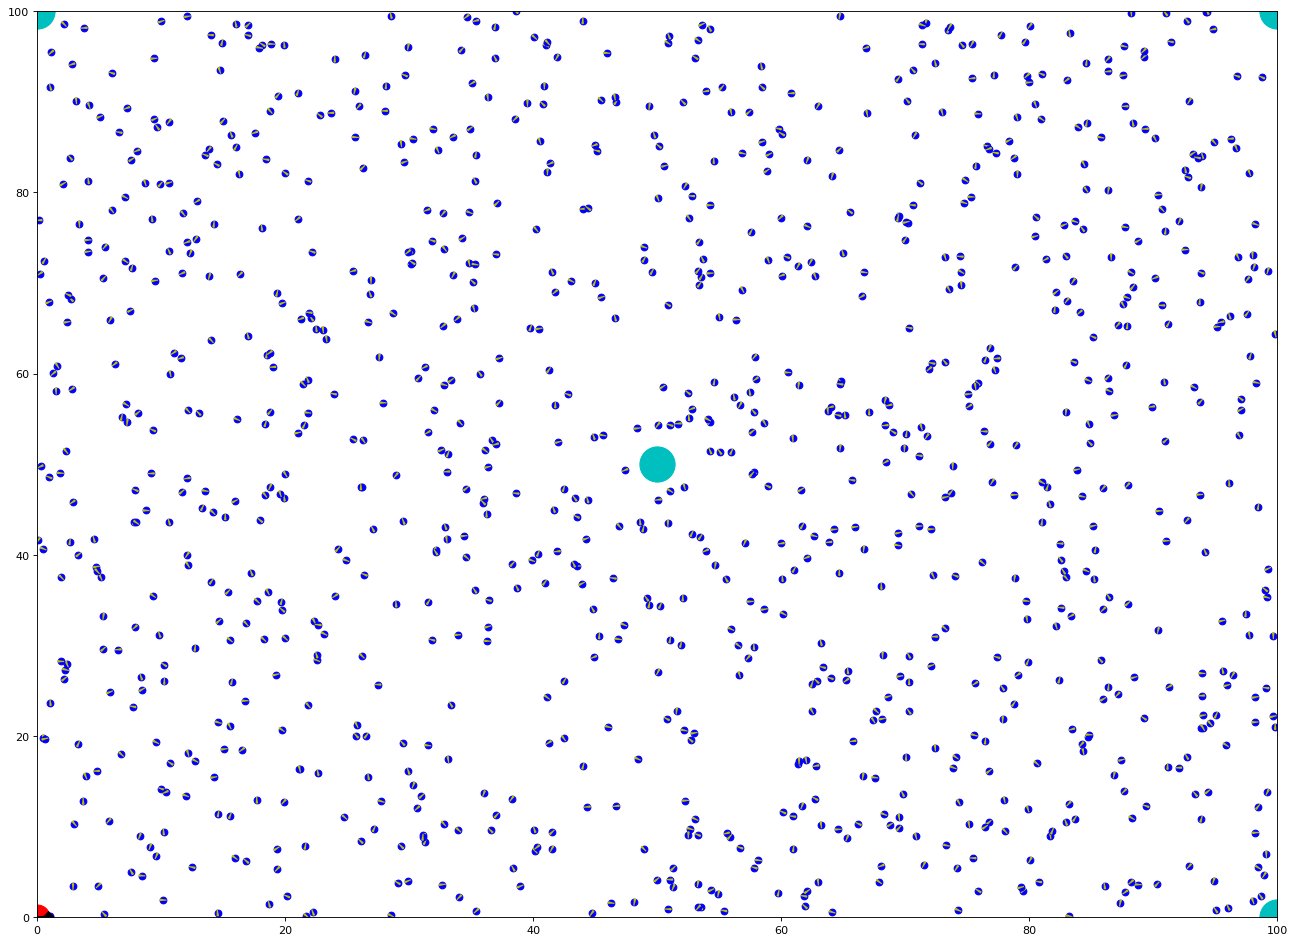

Step:  0
Robot location: Robot pose is: [x=9.590 y=2.716 orient=0.275]
Mean error: 3.6771004071220905


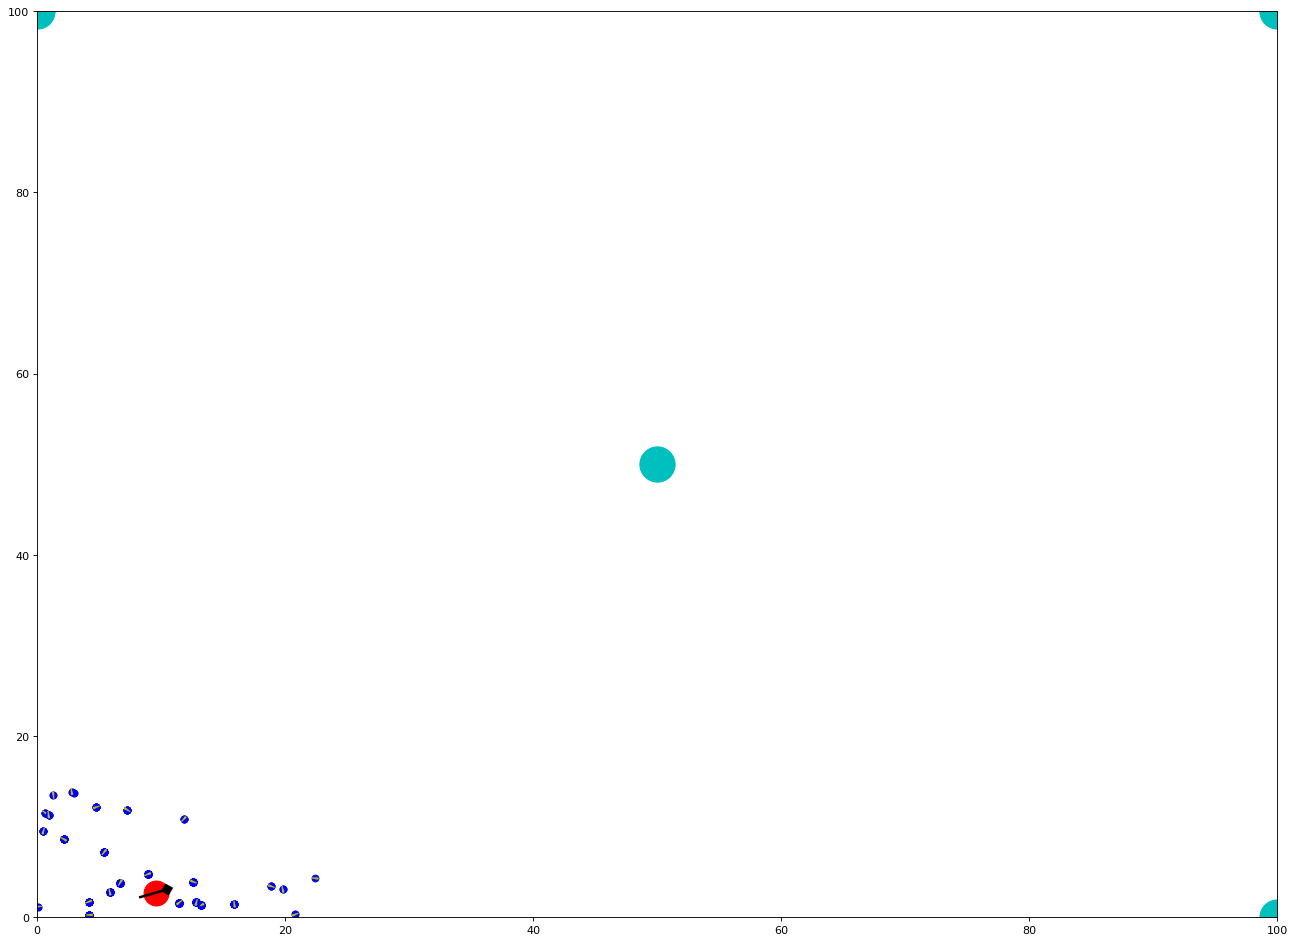

Step:  1
Robot location: Robot pose is: [x=18.92 y=6.768 orient=0.409]
Mean error: 3.8354843258676765


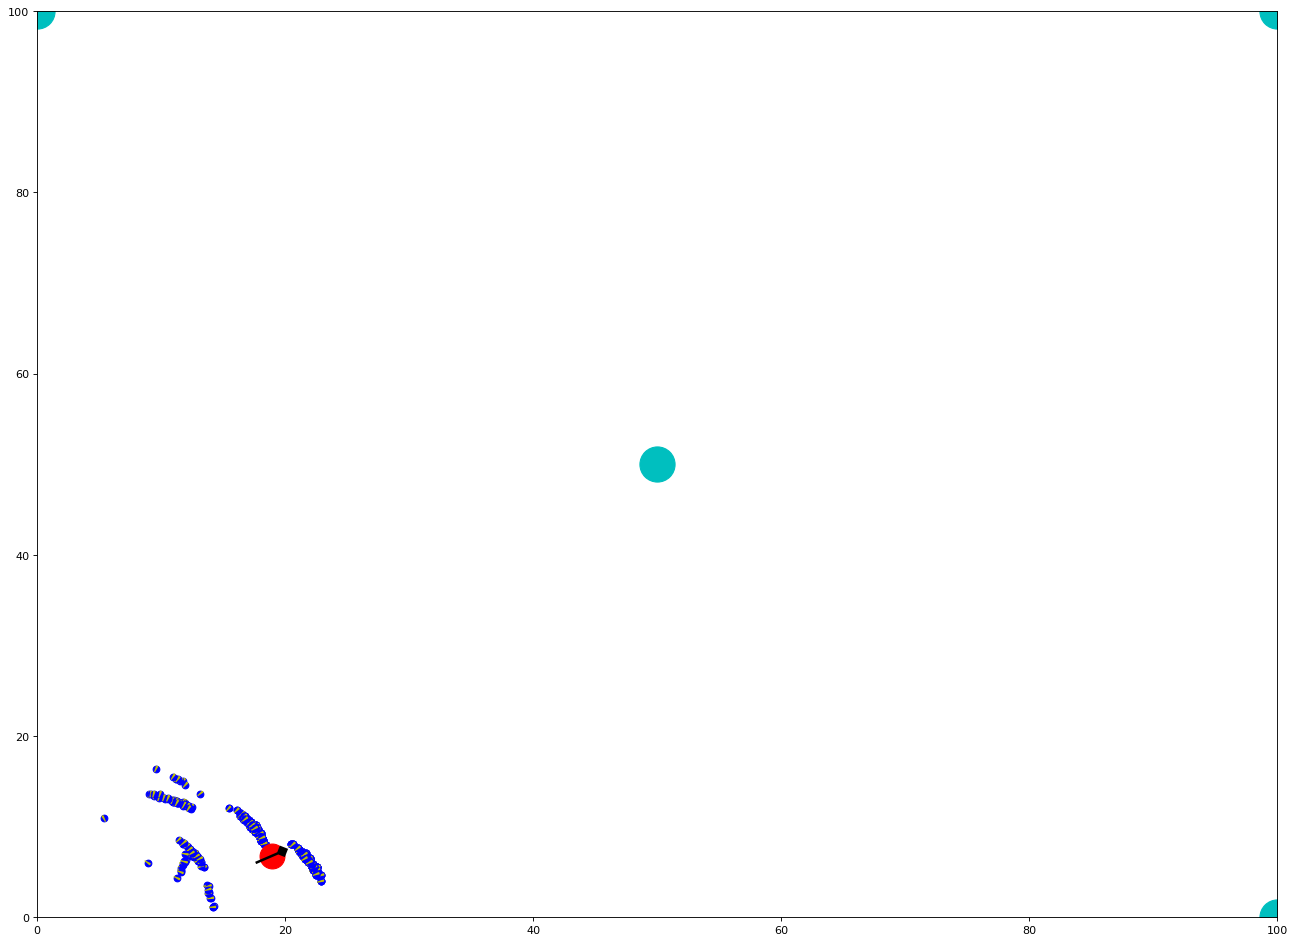

Step:  2
Robot location: Robot pose is: [x=27.02 y=12.60 orient=0.624]
Mean error: 3.16333403947097


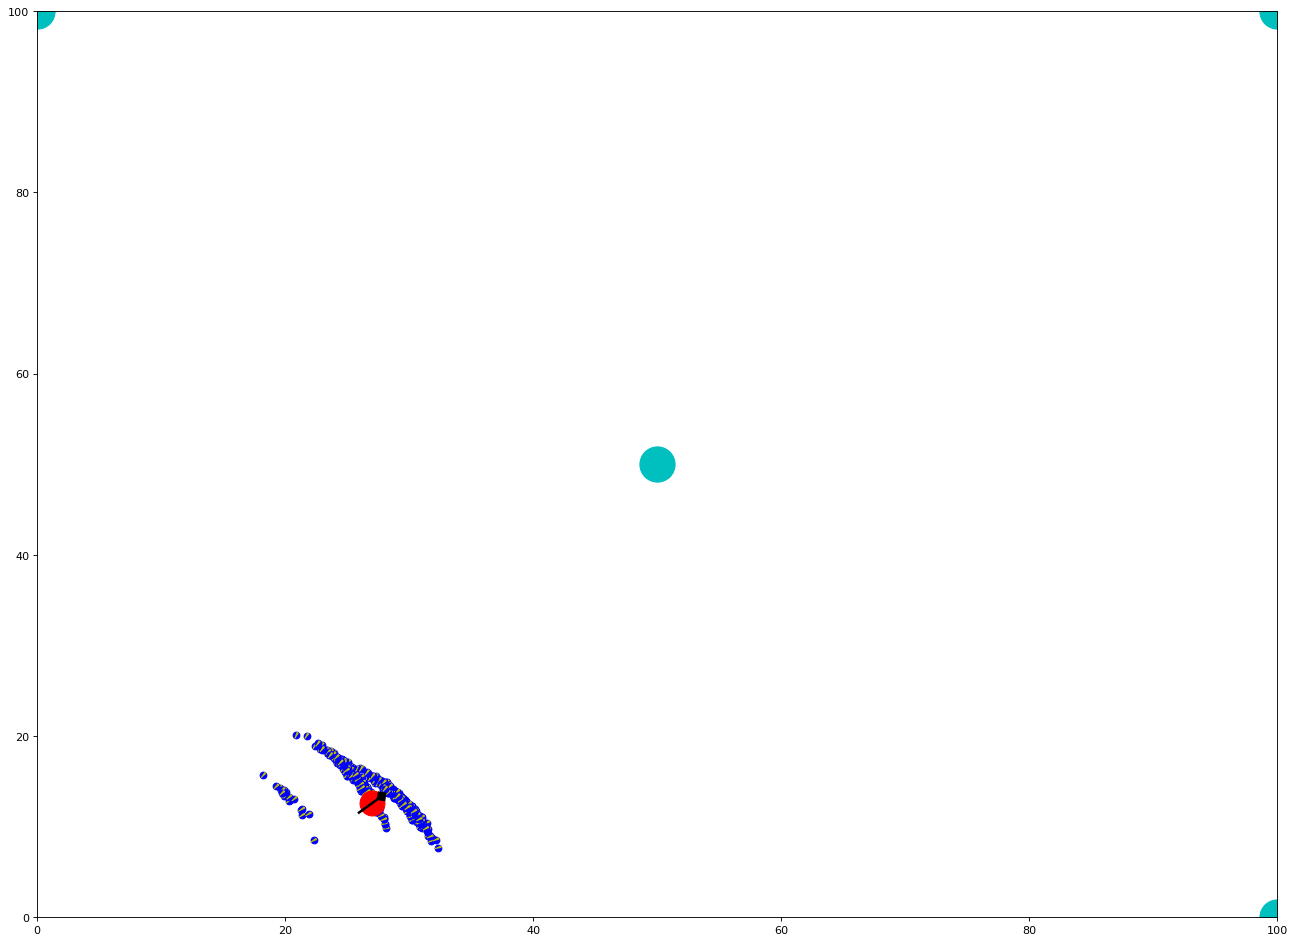

Step:  3
Robot location: Robot pose is: [x=34.14 y=19.76 orient=0.788]
Mean error: 2.778890085280815


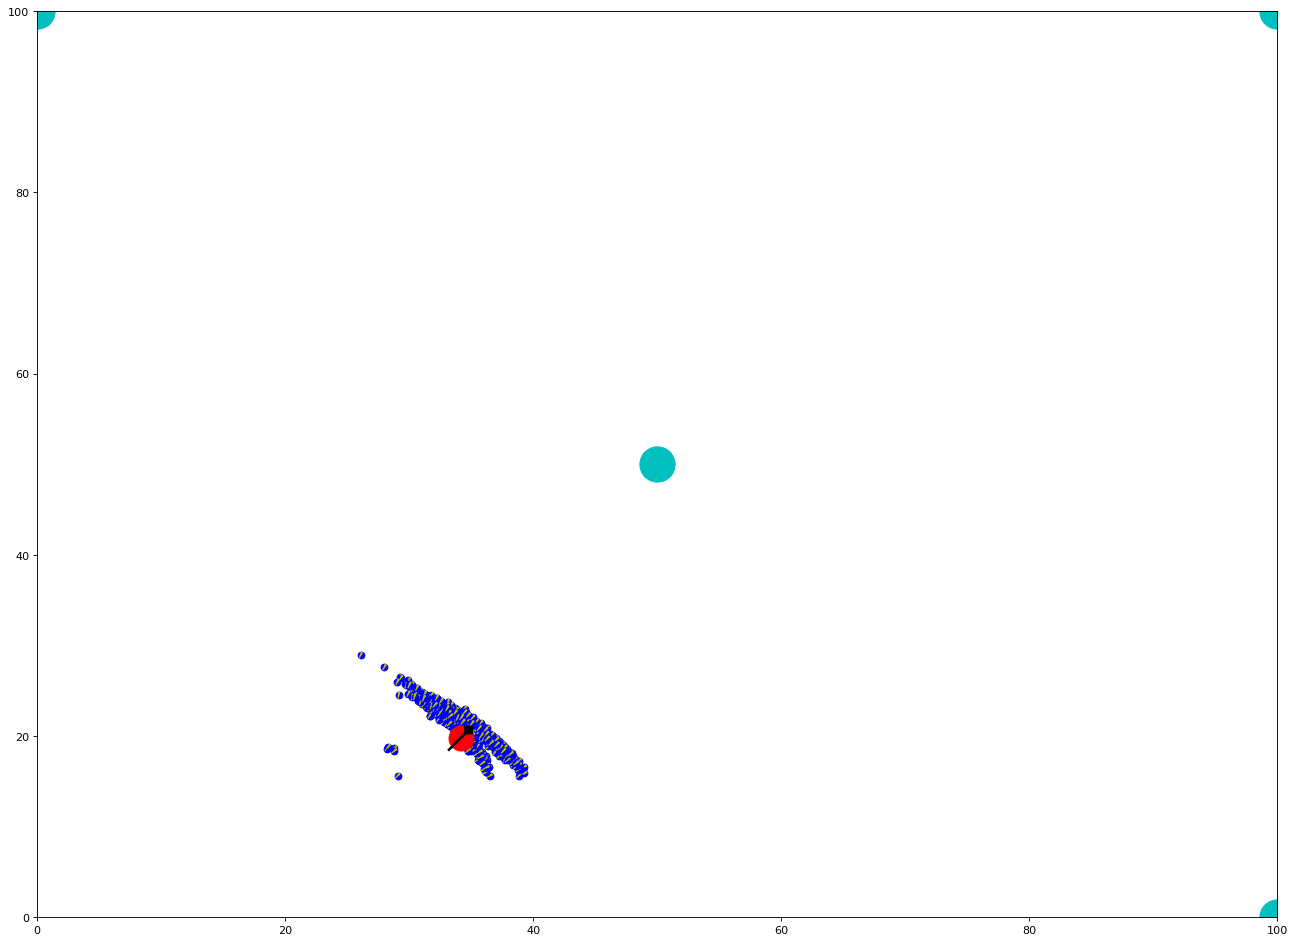

Step:  4
Robot location: Robot pose is: [x=40.31 y=27.64 orient=0.906]
Mean error: 2.550903906041312


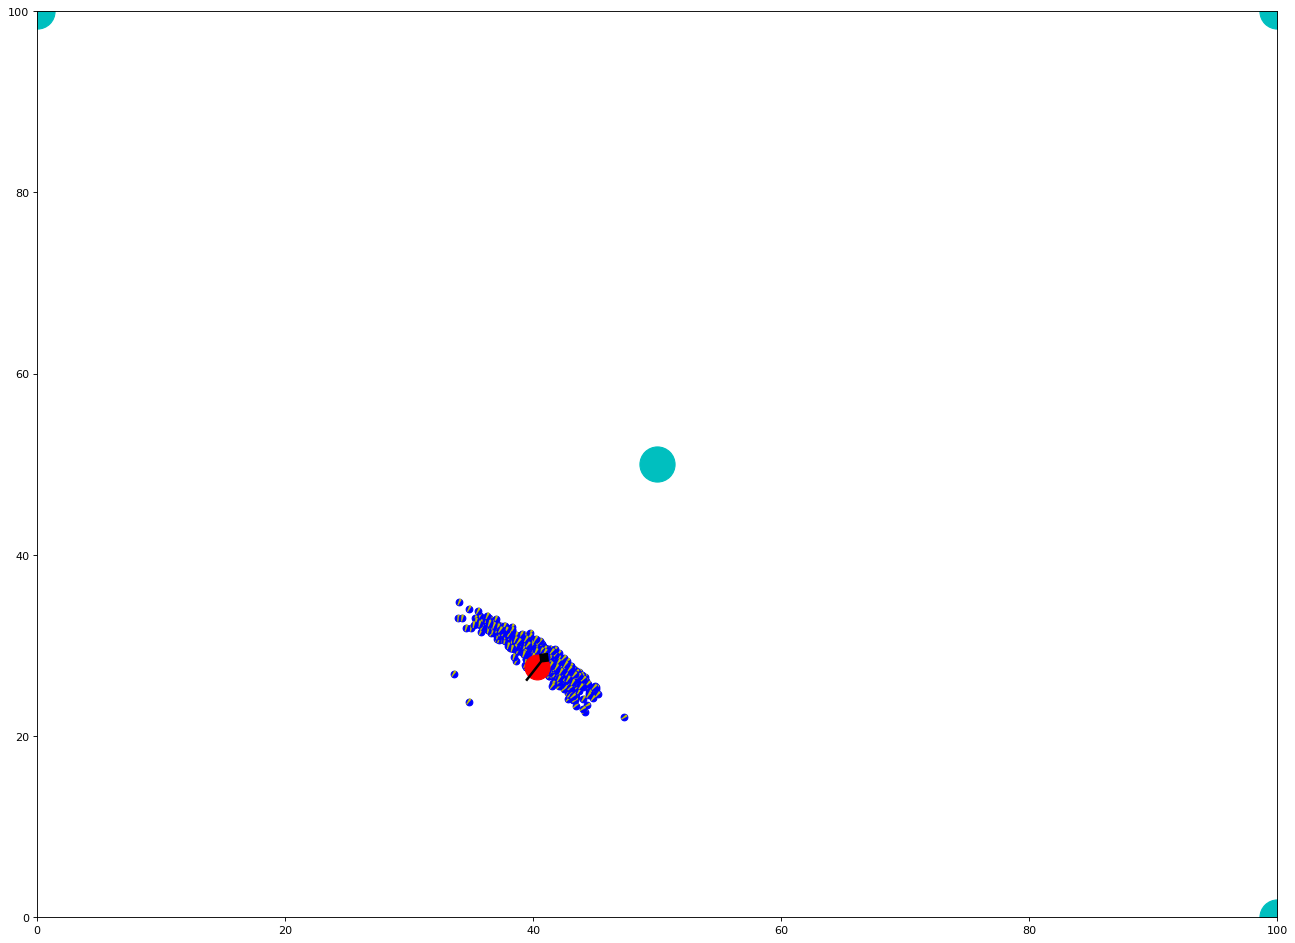

Step:  5
Robot location: Robot pose is: [x=44.75 y=36.63 orient=1.111]
Mean error: 2.5458881010303216


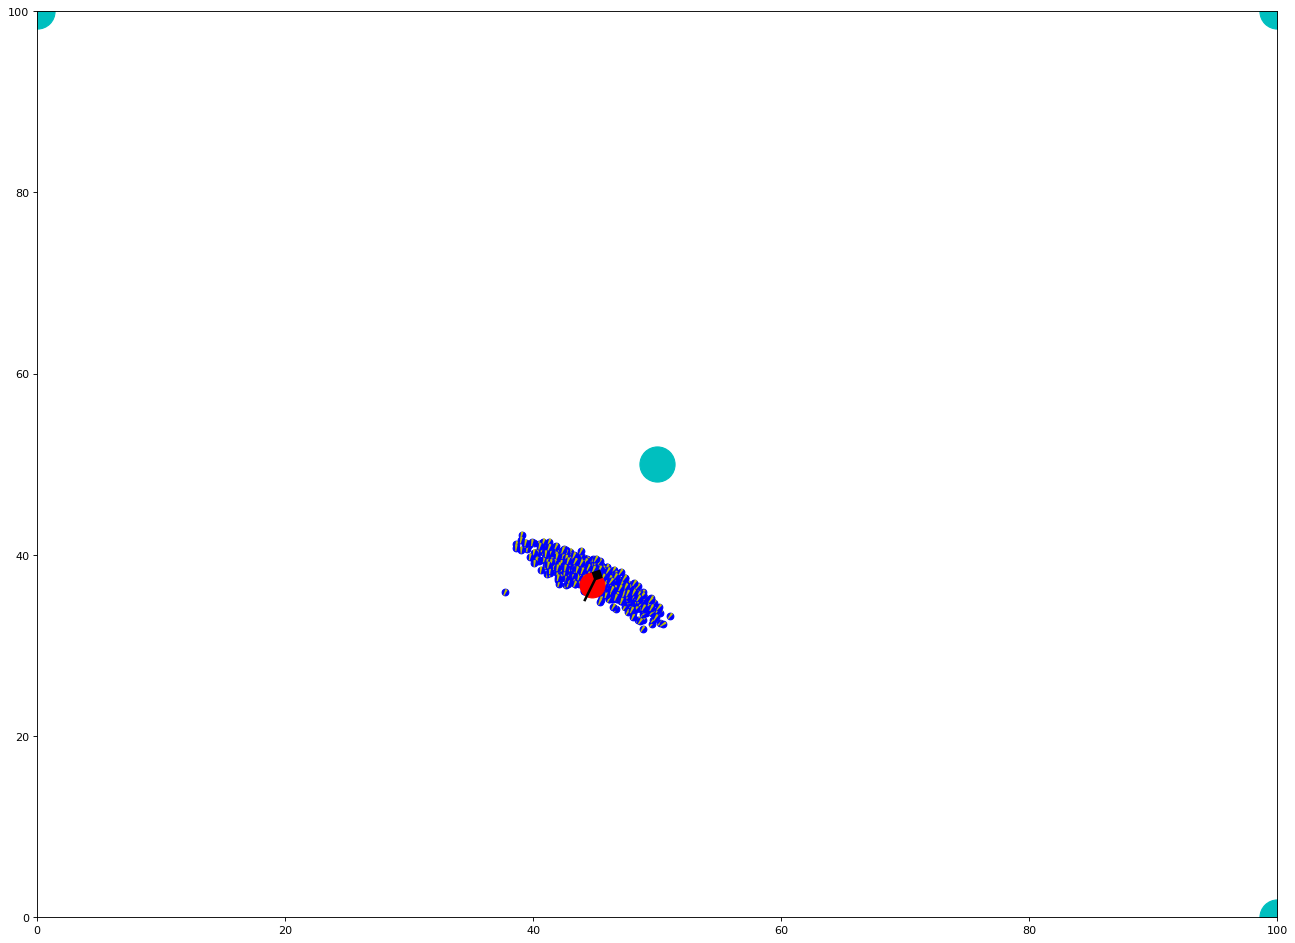

Step:  6
Robot location: Robot pose is: [x=47.16 y=46.12 orient=1.322]
Mean error: 2.6214125593585758


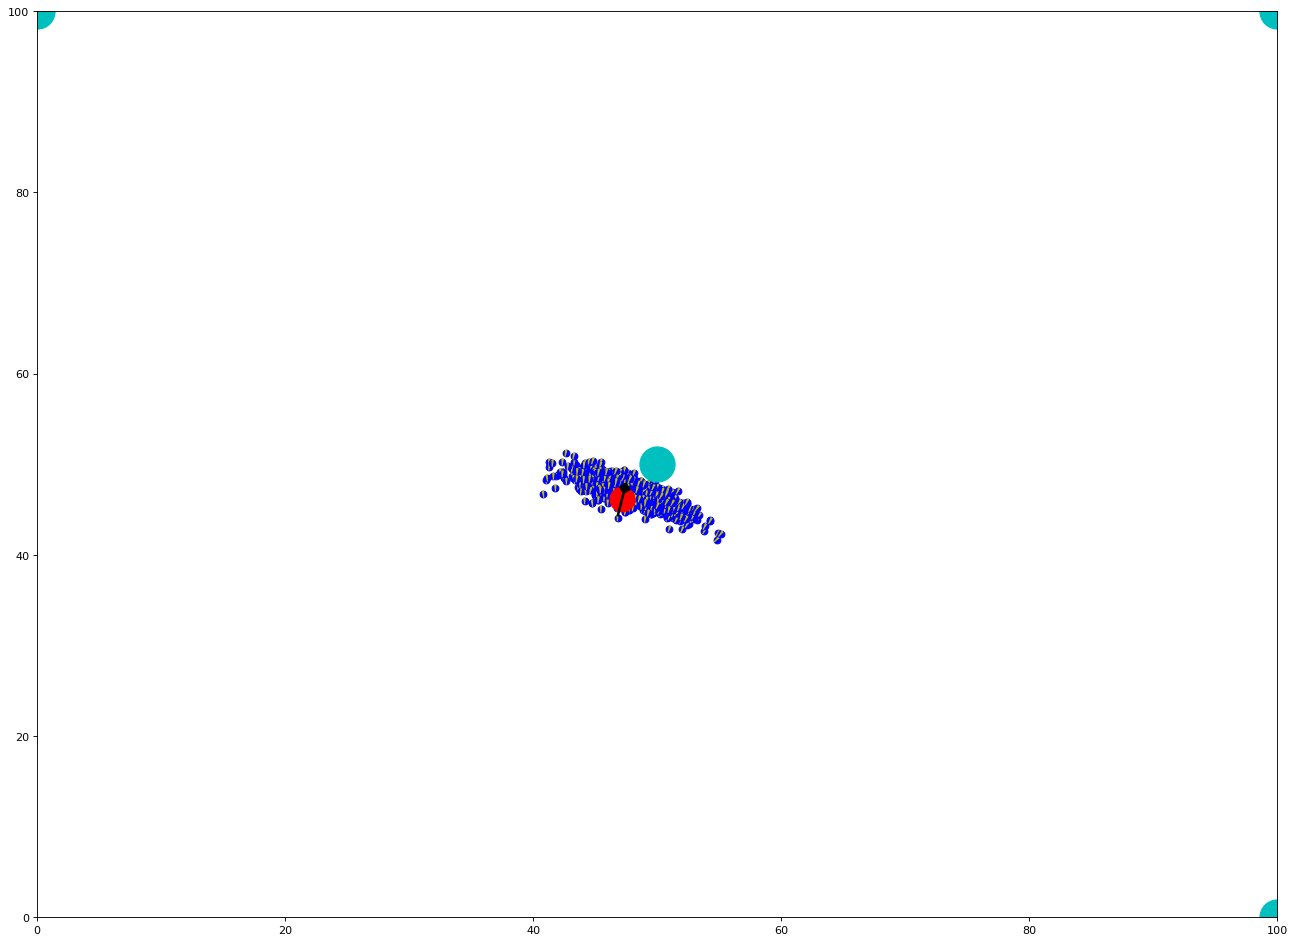

Step:  7
Robot location: Robot pose is: [x=47.58 y=56.05 orient=1.528]
Mean error: 2.6159746692159778


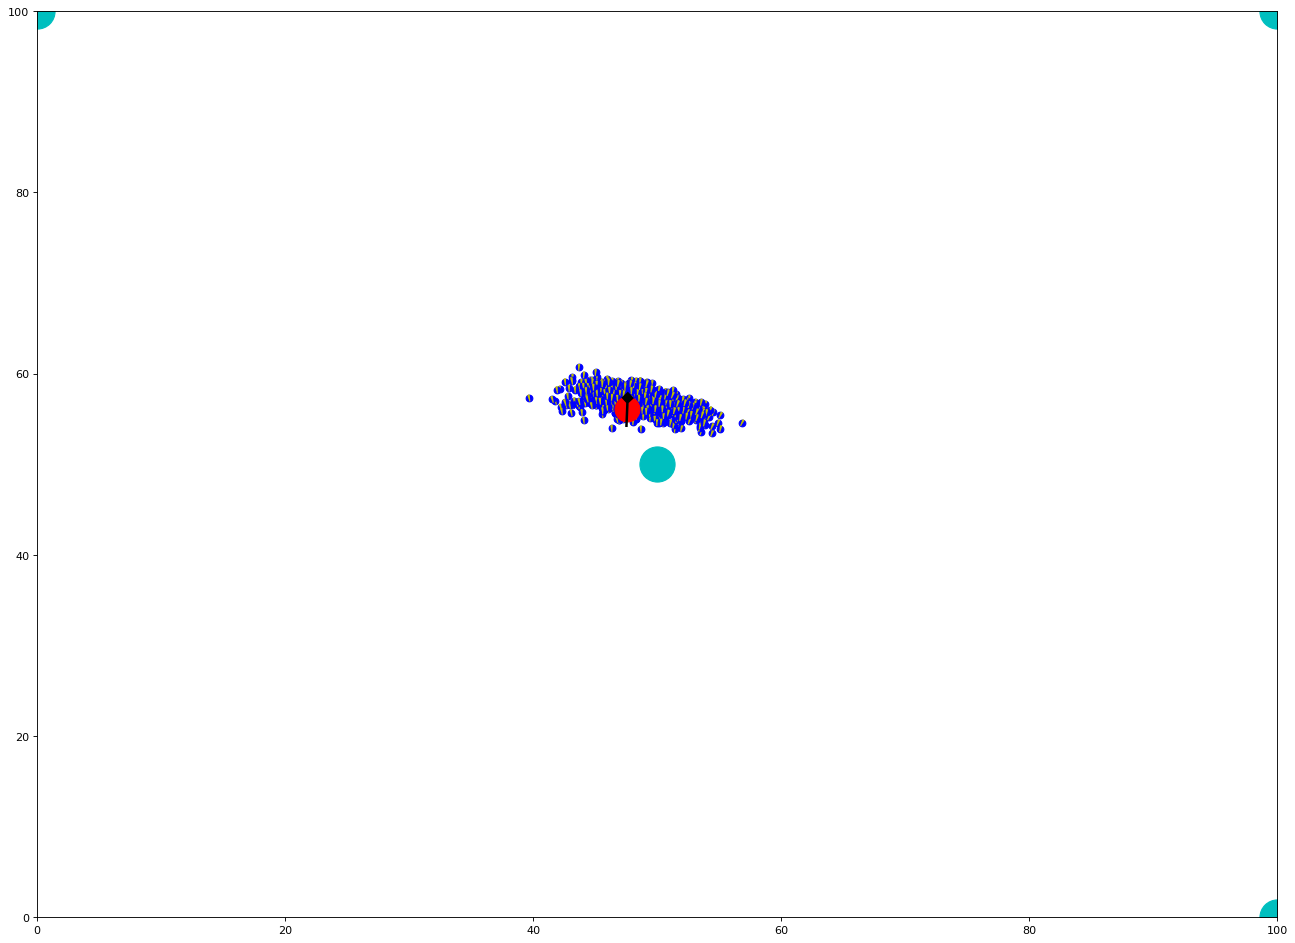

Step:  8
Robot location: Robot pose is: [x=45.83 y=65.78 orient=1.748]
Mean error: 2.8186746881473472


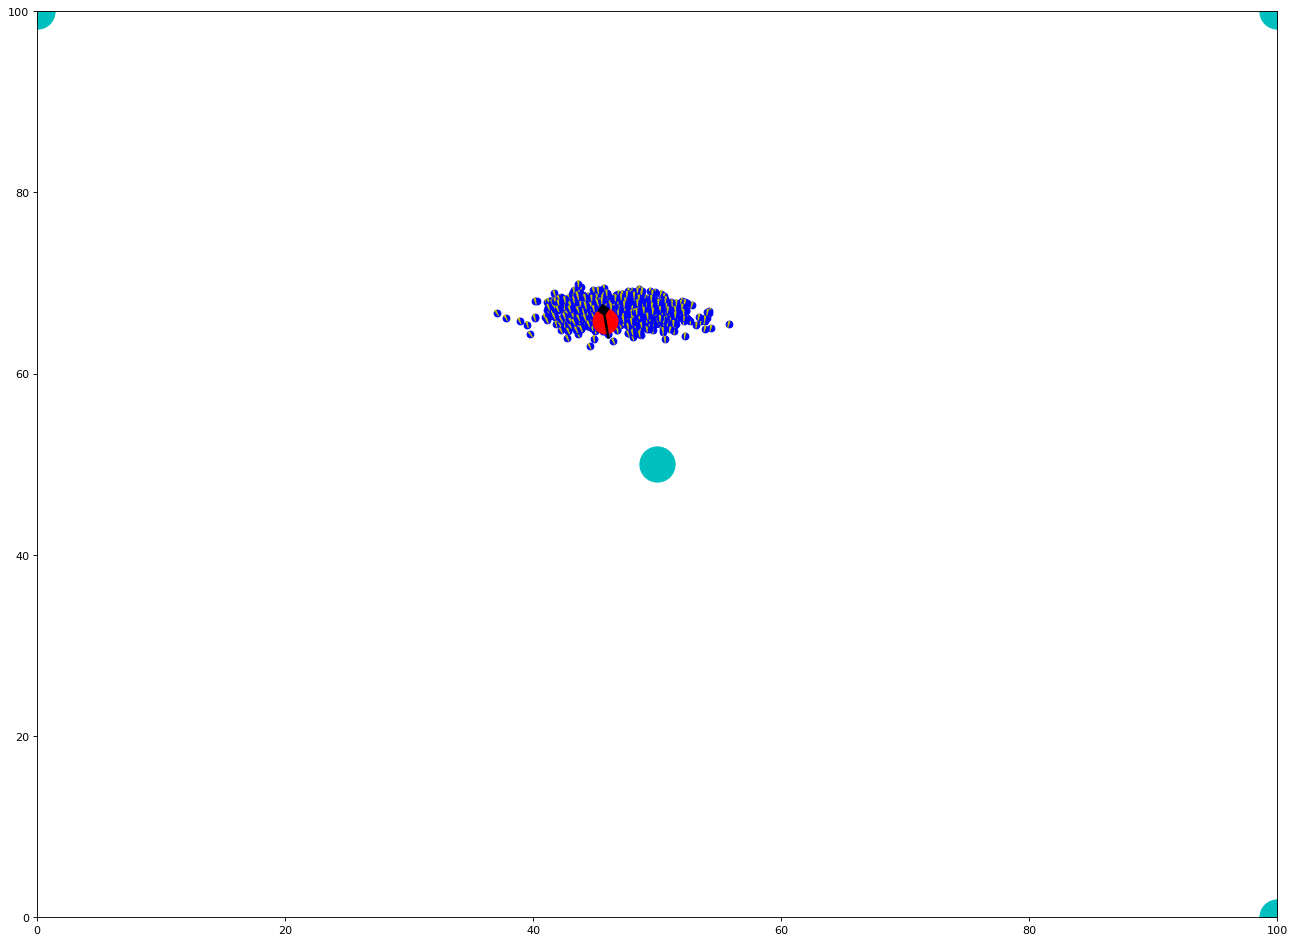

Step:  9
Robot location: Robot pose is: [x=42.72 y=74.99 orient=1.896]
Mean error: 2.8595122199468976


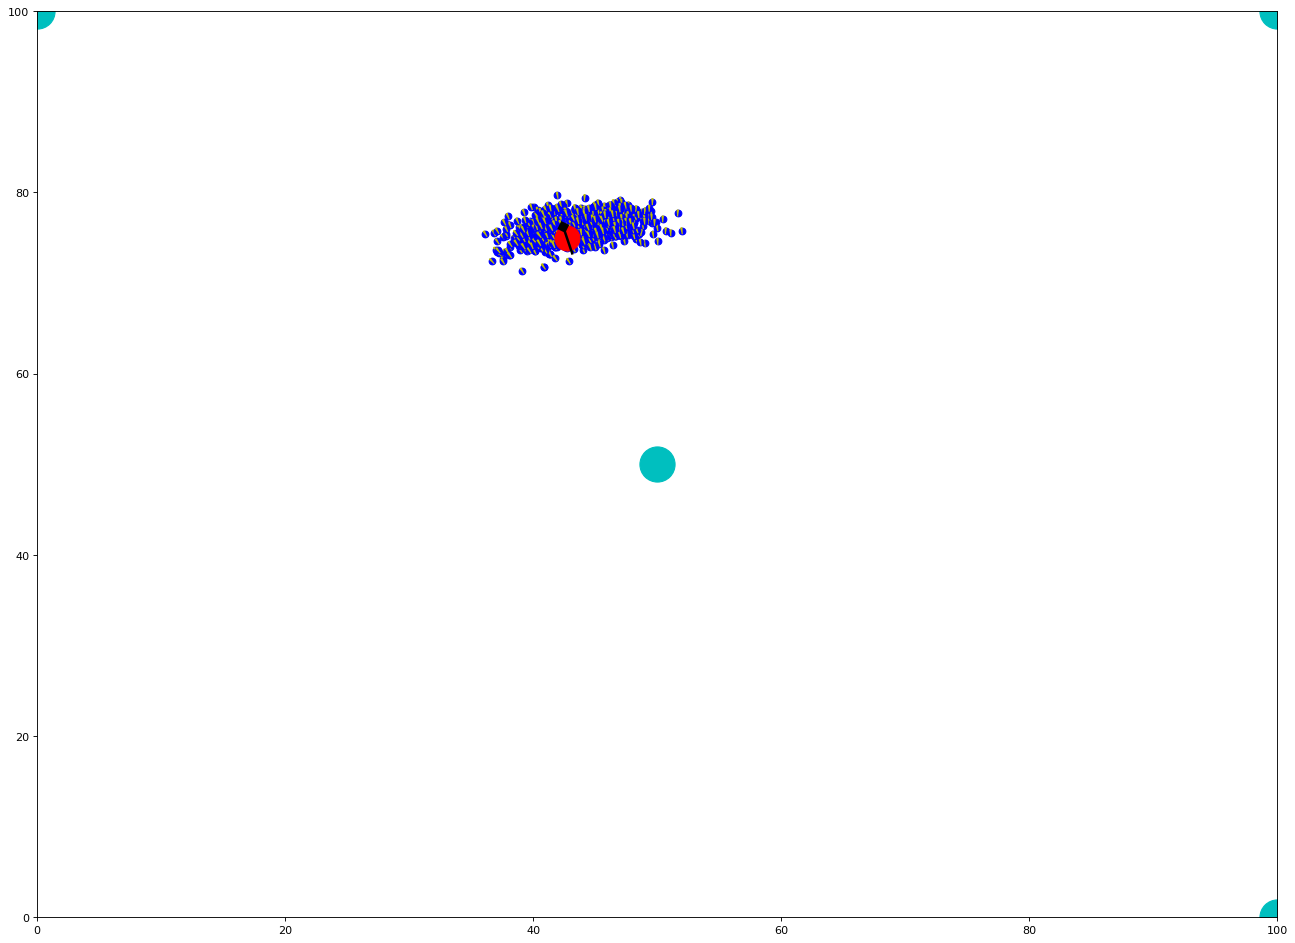

In [11]:
main()